In [2]:
from typing import cast
from itertools import combinations
import numpy as np
import scipy.optimize as opt
from pyscf import gto
from qiskit import QuantumCircuit
from qiskit_aer import AerProvider
from qc_practice import VQE, SSVQE, VQD
from qc_practice.ansatz import UCCSD, UpCCGSD, UpCCSD, UCCGSD, HEA, SP, RSP, OSP

1. run VQE

In [1]:
mol = gto.M(atom = 'H 0 0 0; H 0 0 0.7', basis = 'sto-3g')
vqd = VQD(mol)
vqd.ansatz = UCCSD()

vqd.parallel = False
vqd.run(shots = 10000)

NameError: name 'gto' is not defined

In [6]:
vqd._config['profiles'].show()

[{'state': 0,
  'spin': '0.00',
  'num_orb': 2,
  'num_elec': 2,
  'coeff': array([-0.02930801, -0.03767891,  0.192386  , -1.49860732, -1.13630275,
         -1.51363343, -0.55304827,  2.02765779,  0.82908045, -1.53003656,
         -1.84496568,  0.47143061,  0.89307402, -2.09644964, -0.80564447,
         -1.42277325]),
  'energy_elec': array(-1.89412366),
  'energy_nucl': 0.7559674441714287,
  'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f9255a0b910>},
 {'state': 1,
  'spin': '0.00',
  'num_orb': 2,
  'num_elec': 2,
  'coeff': array([-2.78328083, -0.32329619, -1.69349255, -1.62727456, -0.76625941,
          1.36201725,  0.74772   , -1.73531607, -0.85889819, -2.52039822,
          0.76892076,  0.71642991,  1.81342193, -0.67460997, -0.86834408,
          0.78893288]),
  'energy_elec': array(-0.84771829),
  'energy_nucl': 0.7559674441714287,
  'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f92443fbb10>},
 {'state': 2,
  'spin': '0.00',
  'num_orb': 2,
  'n

2. set qc[0] as the ground state

In [265]:
number_of_states = 2

no = vqe.profile.num_orb
qc = [QuantumCircuit(no*2) for _ in range(number_of_states)]
ancila = QuantumCircuit(1, 1)

vqe._initialize_circuit(qc[0])
vqe.ansatz.ansatz(qc[0], vqe.profile, vqe.profile.coeff)


coeff = vqe.ansatz.generate_coeff(vqe.profile)
vqe._initialize_circuit(qc[1])
qc[1].swap(0, 1)
vqe.ansatz.ansatz(qc[1], vqe.profile, vqe.profile.coeff)

3. measuring overlap

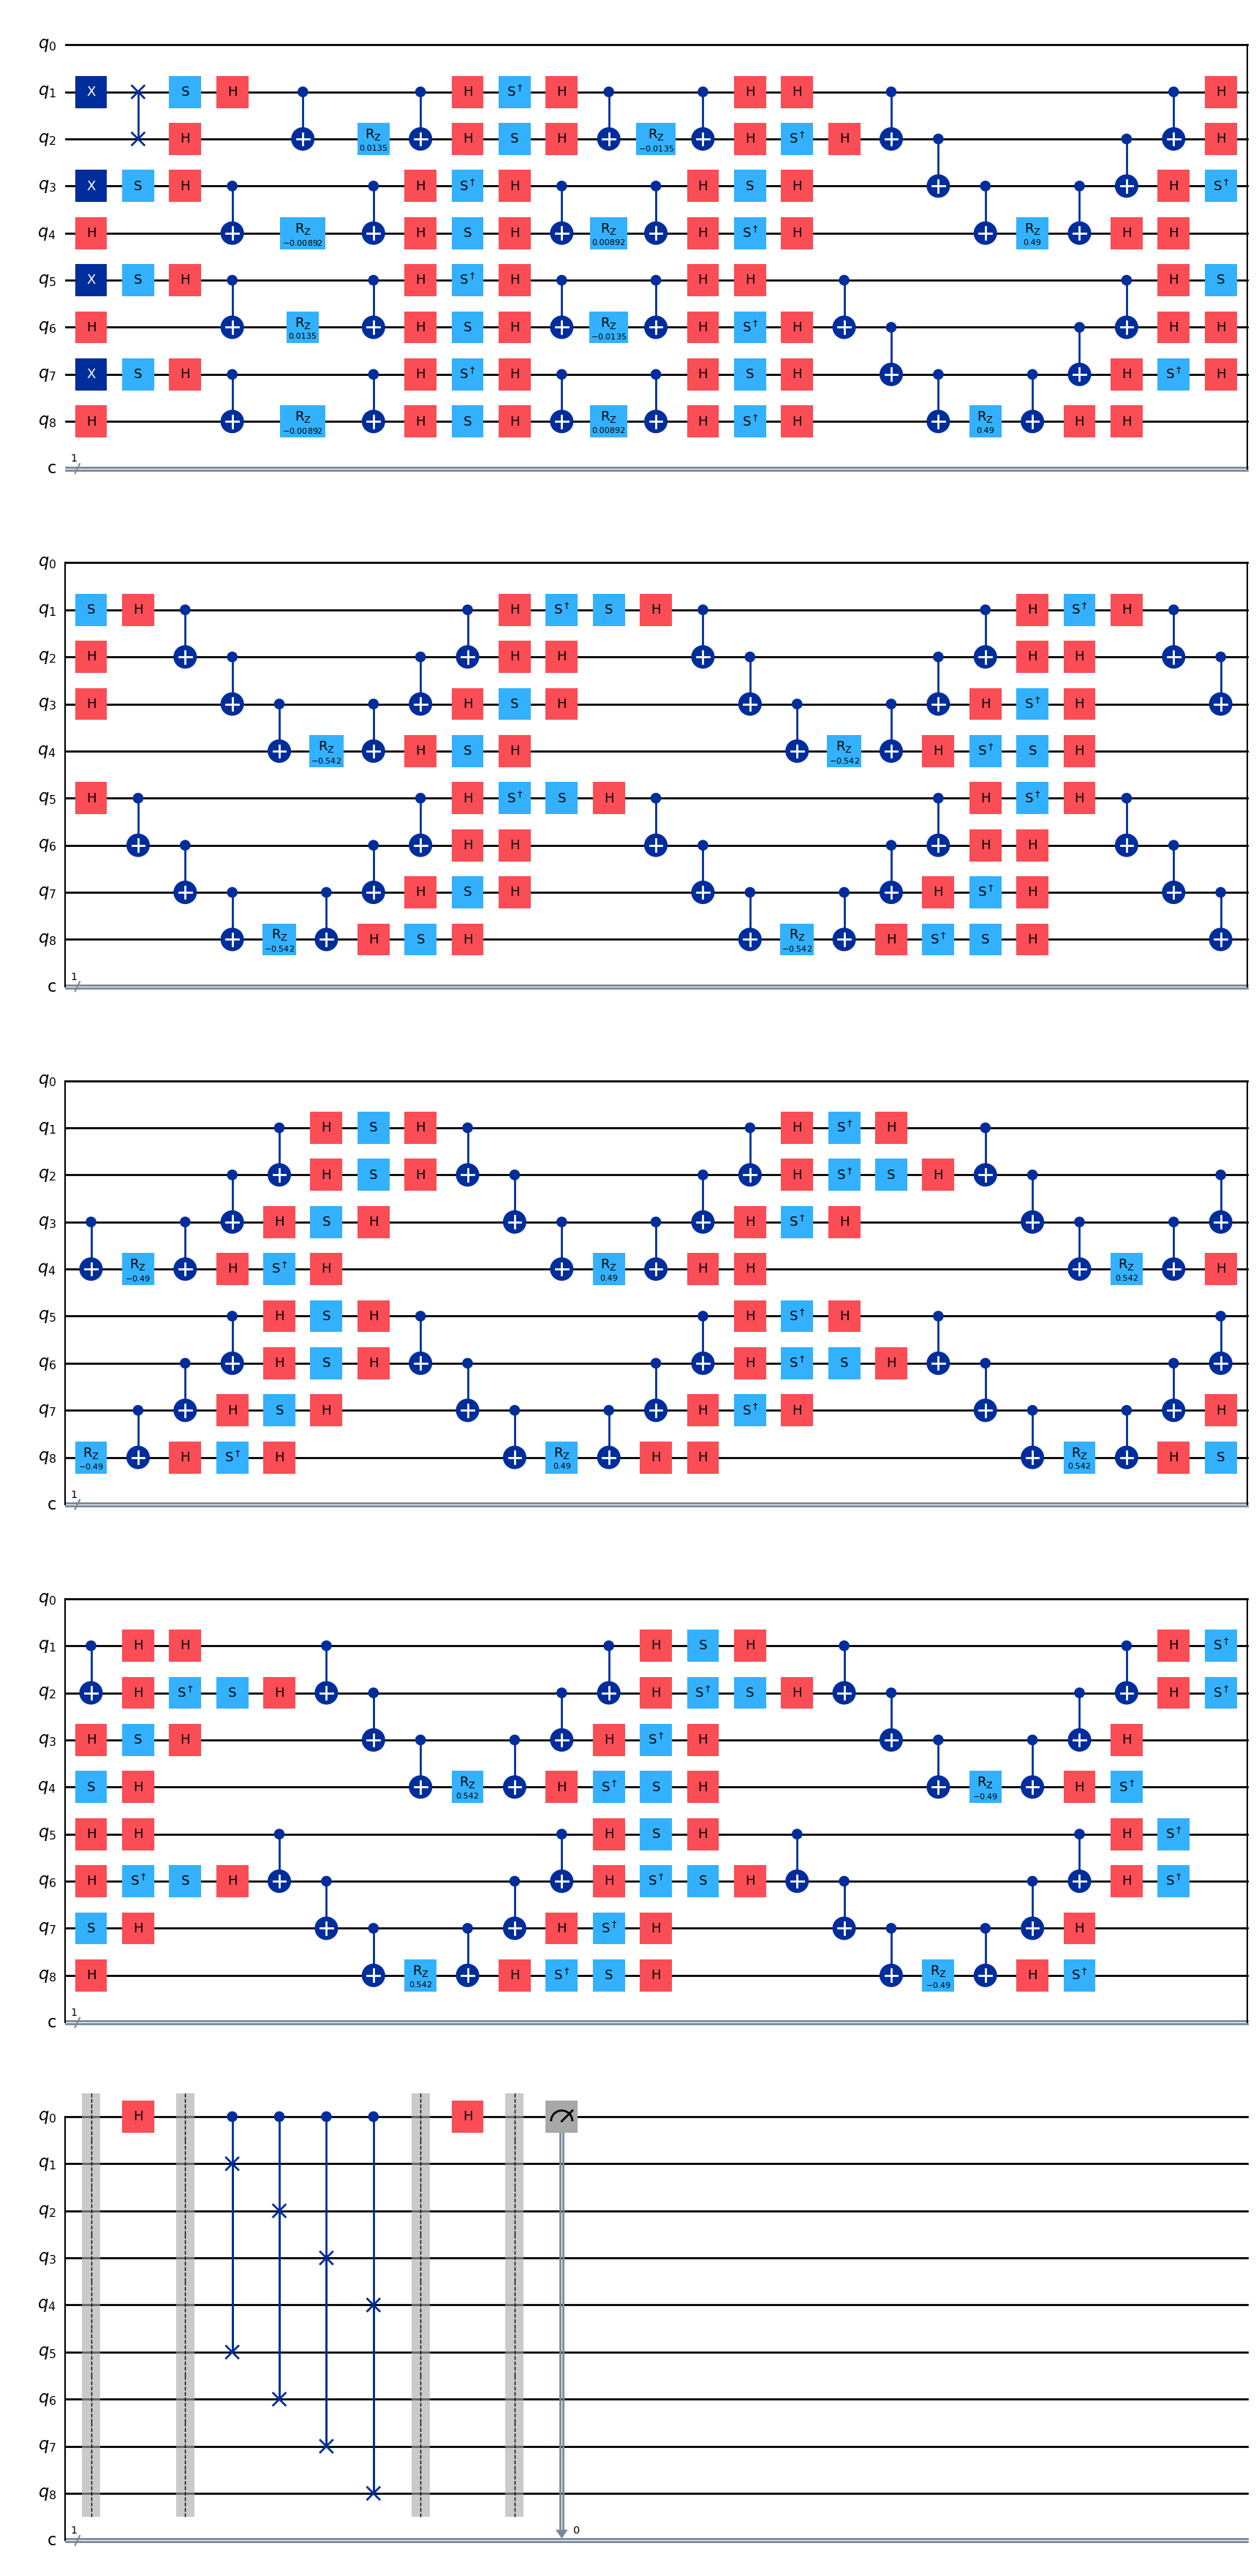

In [277]:
no = vqe.profile.num_orb
ancila = QuantumCircuit(1, 1)
qc_total = qc[0].tensor(qc[1]).tensor(ancila)
qc_total.barrier()
qc_total.h(0)
qc_total.barrier()
for i in range(1, no*2+1):
    qc_total.cswap(0, i, i+no*2)
qc_total.barrier()
qc_total.h(0)
qc_total.barrier()

qc_total.measure(0, 0)
qc_total.draw('mpl')

# backend = AerProvider().get_backend('qasm_simulator')
# result = cast(dict[str, float],
#             backend.run(qc_total, shots=10000).result().get_counts())
# print(result)

In [276]:
def measure_overlap(qc1, qc2):
    no = vqe.profile.num_orb
    shots = 10000
    ancila = QuantumCircuit(1, 1)
    qc_total = qc[0].tensor(qc[1]).tensor(ancila)
    qc_total.h(0)
    for i in range(1, no*2+1):
        qc_total.cswap(0, i, i+no*2)
    qc_total.h(0)
    qc_total.measure(0, 0)

    backend = AerProvider().get_backend('qasm_simulator')
    result = backend.run(qc_total, shots=shots).result().get_counts()
    print(result)
    overlap_sq = abs(result.get('0') / shots * 2 - 1)
    return overlap_sq

measure_overlap(qc[0], qc[1])

/tmp/ipykernel_29173/461502434.py:12: DeprecationWarning: The class ``qiskit.providers.provider.Provider`` is deprecated as of qiskit 1.1. It will be removed no earlier than 3 months after the release date. The abstract Provider and ProviderV1 classes are deprecated and will be removed in 2.0. You can just remove it as the parent class and a `get_backend` method that returns the backends from `self.backend`.
  backend = AerProvider().get_backend('qasm_simulator')


{'0': 500298, '1': 499702}
overlap: 0.024413, overlap_sq: 0.000596


4. make cost function

In [ ]:
def cost_func(qc, beta):
    state = len(qc)-1
    energy = vqe._measure(qc[len(qc)-1])
    

4. run optimizer